# Train a Neural ODE with Optax

We can use the parameter estimation functionality to fit a neural ODE to a time series data set.

In [1]:
"""Train a neural ODE with ProbDiffEq and Optax."""
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import ivpsolve
from probdiffeq.impl import impl
from probdiffeq.solvers import solution, uncalibrated
from probdiffeq.solvers.strategies import smoothers
from probdiffeq.solvers.strategies.components import corrections, priors
from probdiffeq.util.doc_util import notebook

In [2]:
plt.rcParams.update(notebook.plot_style())
plt.rcParams.update(notebook.plot_sizes())

In [3]:
if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

# Catch NaN gradients in CI
# Disable to improve speed
config.update("jax_debug_nans", True)

config.update("jax_platform_name", "cpu")

In [4]:
impl.select("isotropic", ode_shape=(1,))

To keep the problem nice and small, assume that the data set is a trigonometric function (which solve differential equations).

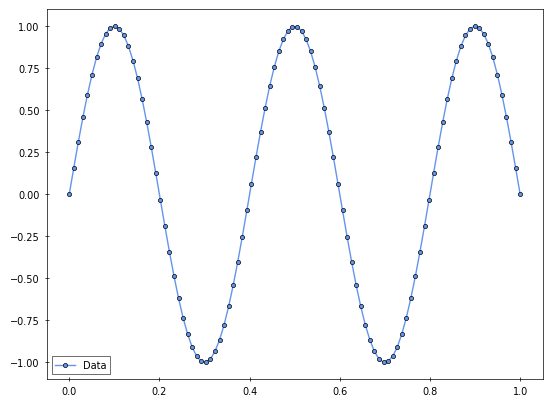

In [5]:
grid = jnp.linspace(0, 1, num=100)
data = jnp.sin(5 * jnp.pi * grid)

plt.plot(grid, data, ".-", label="Data")
plt.legend()
plt.show()

In [6]:
def build_loss_fn(vf, initial_values, solver, *, standard_deviation=1e-2):
    """Build a loss function from an ODE problem."""

    @jax.jit
    def loss_fn(parameters):
        """Loss function: log-marginal likelihood of the data."""
        tcoeffs = (*initial_values, vf(*initial_values, t=t0, p=parameters))
        init = solver.initial_condition(tcoeffs, output_scale=1.0)

        sol = ivpsolve.solve_fixed_grid(
            lambda *a, **kw: vf(*a, **kw, p=parameters), init, grid=grid, solver=solver
        )

        observation_std = jnp.ones_like(grid) * standard_deviation
        marginal_likelihood = solution.log_marginal_likelihood(
            data[:, None], standard_deviation=observation_std, posterior=sol.posterior
        )
        return -1 * marginal_likelihood

    return loss_fn

In [7]:
def build_update_fn(*, optimizer, loss_fn):
    """Build a function for executing a single step in the optimization."""

    @jax.jit
    def update(params, opt_state):
        """Update the optimiser state."""
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    return update

## Construct an MLP with tanh activation

Let's start with the example given in the [implicit layers tutorial](http://implicit-layers-tutorial.org/neural_odes/). The vector field is provided by [DiffEqZoo](https://diffeqzoo.readthedocs.io/).

In [8]:
f, u0, (t0, t1), f_args = ivps.neural_ode_mlp(layer_sizes=(2, 20, 1))


@jax.jit
def vf(y, *, t, p):
    """Evaluate the MLP."""
    return f(y, t, *p)


# Make a solver
ibm = priors.ibm_adaptive(num_derivatives=1)
ts0 = corrections.ts0()
strategy = smoothers.smoother_adaptive(ibm, ts0)
solver_ts0 = uncalibrated.solver(strategy)

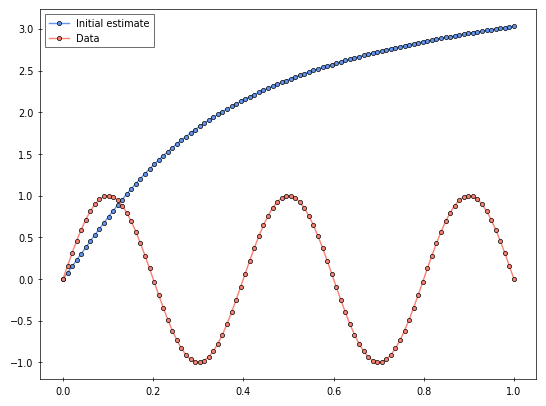

In [9]:
tcoeffs = (u0, vf(u0, t=t0, p=f_args))
init = solver_ts0.initial_condition(tcoeffs, output_scale=1.0)

sol = ivpsolve.solve_fixed_grid(
    lambda *a, **kw: vf(*a, **kw, p=f_args), init, grid=grid, solver=solver_ts0
)

plt.plot(sol.t, sol.u, ".-", label="Initial estimate")
plt.plot(grid, data, ".-", label="Data")
plt.legend()
plt.show()

## Set up a loss function and an optimiser

Like in the other tutorials, we use [Optax](https://optax.readthedocs.io/en/latest/index.html).

In [10]:
loss_fn = build_loss_fn(vf=vf, initial_values=(u0,), solver=solver_ts0)
optim = optax.adam(learning_rate=2e-2)
update_fn = build_update_fn(optimizer=optim, loss_fn=loss_fn)

In [11]:
p = f_args
state = optim.init(p)
chunk_size = 25
for i in range(chunk_size):
    for _ in range(chunk_size**2):
        p, state = update_fn(p, state)
    print(
        "Negative log-marginal-likelihood after "
        f"{(i+1)*chunk_size**2}/{chunk_size**3} steps:",
        loss_fn(p),
    )

Negative log-marginal-likelihood after 625/15625 steps: 1769.1573


Negative log-marginal-likelihood after 1250/15625 steps: 1476.7445


Negative log-marginal-likelihood after 1875/15625 steps: 1792.2786


Negative log-marginal-likelihood after 2500/15625 steps: 1260.9396


Negative log-marginal-likelihood after 3125/15625 steps: 1193.5592


Negative log-marginal-likelihood after 3750/15625 steps: 969.38385


Negative log-marginal-likelihood after 4375/15625 steps: 779.4457


Negative log-marginal-likelihood after 5000/15625 steps: 547.1318


Negative log-marginal-likelihood after 5625/15625 steps: 286.30353


Negative log-marginal-likelihood after 6250/15625 steps: 114.161385


Negative log-marginal-likelihood after 6875/15625 steps: 71.54484


Negative log-marginal-likelihood after 7500/15625 steps: 50.21077


Negative log-marginal-likelihood after 8125/15625 steps: 38.335773


Negative log-marginal-likelihood after 8750/15625 steps: 19.087908


Negative log-marginal-likelihood after 9375/15625 steps: 8.019905


Negative log-marginal-likelihood after 10000/15625 steps: 1.6709937


Negative log-marginal-likelihood after 10625/15625 steps: -1.2912468


Negative log-marginal-likelihood after 11250/15625 steps: -2.6133456


Negative log-marginal-likelihood after 11875/15625 steps: -3.1257315


Negative log-marginal-likelihood after 12500/15625 steps: -3.3087778


Negative log-marginal-likelihood after 13125/15625 steps: -3.4109695


Negative log-marginal-likelihood after 13750/15625 steps: -3.4738586


Negative log-marginal-likelihood after 14375/15625 steps: -3.5077426


Negative log-marginal-likelihood after 15000/15625 steps: -3.5475373


Negative log-marginal-likelihood after 15625/15625 steps: -3.4945862


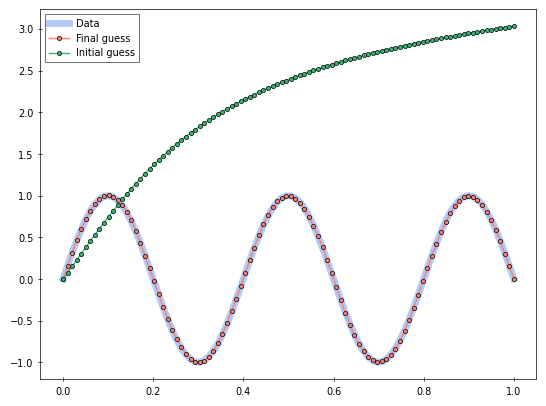

In [12]:
plt.plot(sol.t, data, "-", linewidth=5, alpha=0.5, label="Data")
tcoeffs = (u0, vf(u0, t=t0, p=p))
init = solver_ts0.initial_condition(tcoeffs, output_scale=1.0)

sol = ivpsolve.solve_fixed_grid(
    lambda *a, **kw: vf(*a, **kw, p=p), init, grid=grid, solver=solver_ts0
)


plt.plot(sol.t, sol.u, ".-", label="Final guess")

tcoeffs = (u0, vf(u0, t=t0, p=f_args))
init = solver_ts0.initial_condition(tcoeffs, output_scale=1.0)

sol = ivpsolve.solve_fixed_grid(
    lambda *a, **kw: vf(*a, **kw, p=f_args), init, grid=grid, solver=solver_ts0
)
plt.plot(sol.t, sol.u, ".-", label="Initial guess")


plt.legend()
plt.show()

## What's next


The same example can be constructed with deep learning libraries such as [Equinox](https://docs.kidger.site/equinox/), [Haiku](https://dm-haiku.readthedocs.io/en/latest/), or [Flax](https://flax.readthedocs.io/en/latest/getting_started.html).
To do so, define a corresponding vector field and a parameter set, build a new loss function and repeat.

